In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [102]:
path='Dades/datos_preprocesados.csv'
path_wei= 'Dades/dt_model.csv'
df_cluster=pd.read_csv(path_wei)
df_old=pd.read_csv(path)

In [121]:
df_cluster.columns

Index(['imc', 'asa', 'valor_de_ca125', 'histo_defin', 'grado_histologi',
       'FIGO2023', 'tamano_tumoral', 'afectacion_linf', 'metasta_distan',
       'AP_centinela_pelvico', 'AP_ganPelv', 'AP_glanPaor',
       'recep_est_porcent', 'rece_de_Ppor', 'beta_cateninap',
       'histo_defin__from_pre', 'grado_histologi__from_pre',
       'FIGO2023__from_pre', 'imc_miss', 'tamano_tumoral_miss',
       'valor_de_ca125_miss', 'recep_est_porcent_miss', 'rece_de_Ppor_miss',
       'cluster_3'],
      dtype='object')

In [104]:
var_clau= ['edad_en_cirugia','event','time_days' ]
df_reps= df_cluster[df_cluster.columns.intersection(var_clau)].copy()
df_cluster=df_cluster.drop(columns=var_clau)

In [105]:
df_reps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event            147 non-null    int64  
 1   time_days        147 non-null    int64  
 2   edad_en_cirugia  147 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.6 KB


In [122]:
df_cluster.head()

,imc,asa,valor_de_ca125,histo_defin,grado_histologi,FIGO2023,tamano_tumoral,afectacion_linf,metasta_distan,AP_centinela_pelvico,...,beta_cateninap,histo_defin__from_pre,grado_histologi__from_pre,FIGO2023__from_pre,imc_miss,tamano_tumoral_miss,valor_de_ca125_miss,recep_est_porcent_miss,rece_de_Ppor_miss,cluster_3
0,39.4,2.0,5.648974,2.0,2.0,14.0,1.386294,Missing,1.0,4.0,...,0.0,0,0,0,0,1,0,0,0,3
1,38.8,2.0,3.226844,2.0,1.0,1.0,1.098612,1.0,0.0,4.0,...,0.0,0,0,0,0,0,1,1,1,2
2,36.3,1.0,3.226844,2.0,1.0,11.0,2.079442,1.0,0.0,4.0,...,0.0,0,0,0,0,0,1,0,0,2
3,31.1,1.0,3.226844,2.0,1.0,1.0,1.791759,0.0,0.0,4.0,...,1.0,0,0,0,0,0,1,0,0,2
4,40.6,1.0,3.226844,2.0,1.0,1.0,0.530628,0.0,0.0,4.0,...,2.0,0,0,0,0,0,1,1,1,2


In [109]:
##columnes
vars_num = [
    'imc',
    'valor_de_ca125',
    'tamano_tumoral',
    'recep_est_porcent',
    'rece_de_Ppor']

vars_cat = [
    'asa',
    'histo_defin',
    'grado_histologi',
    'FIGO2023',
    'afectacion_linf',
    'metasta_distan',
    'AP_centinela_pelvico',
    'AP_ganPelv',
    'AP_glanPaor',
    'beta_cateninap'
]

vars_from_pre = [
    'histo_defin__from_pre',
    'grado_histologi__from_pre',
    'FIGO2023__from_pre'
]

vars_flag = [
    'imc_miss',
    'tamano_tumoral_miss',
    'valor_de_ca125_miss',
    'recep_est_porcent_miss',
    'rece_de_Ppor_miss'
]


# Clustering de Pacientes

Vamos a hacer clustering usando todas las variables **excepto**:
- Las variables para el modelo Cox (event, edad_en_cirugia, time_days)
- Las variables flag (*_miss) que solo indican si hubo imputación

In [123]:
# Importar librerías necesarias para clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns

# Preparar datos para clustering
# Excluimos las variables flag y las variables para el modelo Cox
vars_clustering = vars_num + vars_cat + vars_from_pre

print(f"Variables para clustering: {len(vars_clustering)}")
print(f"Numéricas: {vars_num}")
print(f"Categóricas: {vars_cat}")
print(f"From pre: {vars_from_pre}")

Variables para clustering: 18
Numéricas: ['imc', 'valor_de_ca125', 'tamano_tumoral', 'recep_est_porcent', 'rece_de_Ppor']
Categóricas: ['asa', 'histo_defin', 'grado_histologi', 'FIGO2023', 'afectacion_linf', 'metasta_distan', 'AP_centinela_pelvico', 'AP_ganPelv', 'AP_glanPaor', 'beta_cateninap']
From pre: ['histo_defin__from_pre', 'grado_histologi__from_pre', 'FIGO2023__from_pre']


In [124]:
# Verificar columnas disponibles y crear dataframe de trabajo
X = df_cluster[vars_clustering].copy()
print(f"\nDimensiones del dataset: {X.shape}")
print(f"\nValores faltantes por variable:")
print(X.isnull().sum()[X.isnull().sum() > 0])


Dimensiones del dataset: (147, 18)

Valores faltantes por variable:
Series([], dtype: int64)


In [125]:
# Codificar variables categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=vars_cat + vars_from_pre, drop_first=True)

print(f"Dimensiones después de codificación: {X_encoded.shape}")
print(f"\nPrimeras columnas:")
print(X_encoded.columns.tolist()[:20])

Dimensiones después de codificación: (147, 51)

Primeras columnas:
['imc', 'valor_de_ca125', 'tamano_tumoral', 'recep_est_porcent', 'rece_de_Ppor', 'asa_1.0', 'asa_2.0', 'asa_Missing', 'histo_defin_2.0', 'histo_defin_3.0', 'histo_defin_4.0', 'histo_defin_6.0', 'histo_defin_7.0', 'histo_defin_8.0', 'histo_defin_9.0', 'grado_histologi_2.0', 'FIGO2023_1.0', 'FIGO2023_10.0', 'FIGO2023_11.0', 'FIGO2023_12.0']


In [126]:
# Escalar los datos (importante para clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"Datos escalados: {X_scaled.shape}")
print(f"Media: {X_scaled.mean():.4f}")
print(f"Desviación estándar: {X_scaled.std():.4f}")

Datos escalados: (147, 51)
Media: 0.0000
Desviación estándar: 1.0000


## Método del Codo (Elbow Method) para determinar número óptimo de clusters

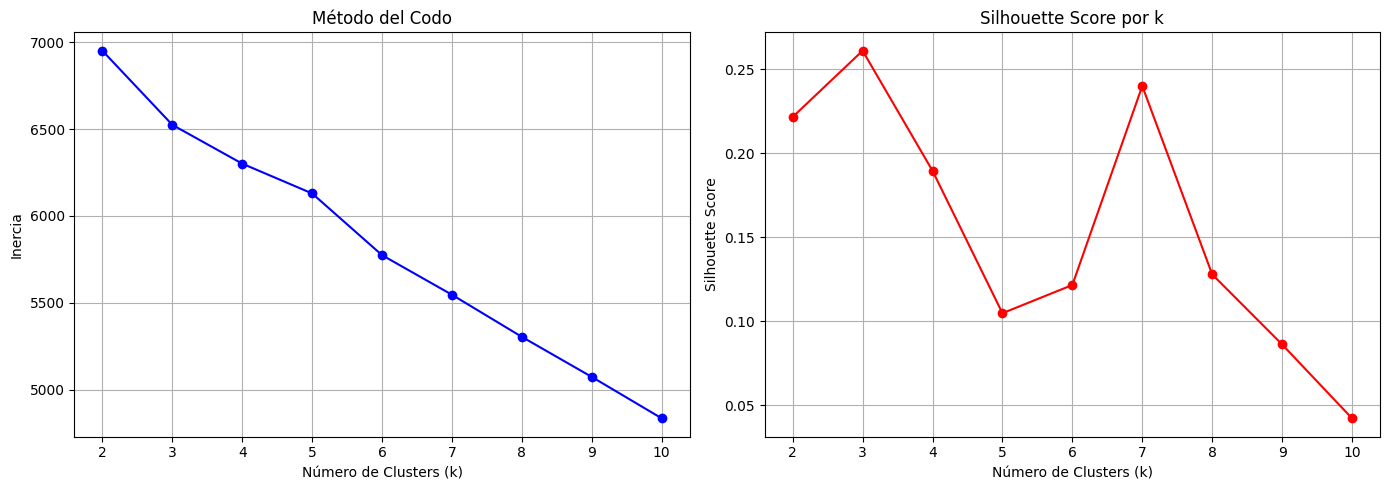


Métricas por número de clusters:
k=2: Inercia=6951.72, Silhouette=0.2215
k=3: Inercia=6524.98, Silhouette=0.2610
k=4: Inercia=6301.43, Silhouette=0.1895
k=5: Inercia=6129.86, Silhouette=0.1047
k=6: Inercia=5774.44, Silhouette=0.1215
k=7: Inercia=5546.42, Silhouette=0.2400
k=8: Inercia=5303.88, Silhouette=0.1278
k=9: Inercia=5073.19, Silhouette=0.0861
k=10: Inercia=4834.75, Silhouette=0.0421


In [127]:
# Método del codo para K-Means
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score por k')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nMétricas por número de clusters:")
for k, inertia, sil in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inercia={inertia:.2f}, Silhouette={sil:.4f}")

## Dendrograma para Clustering Jerárquico

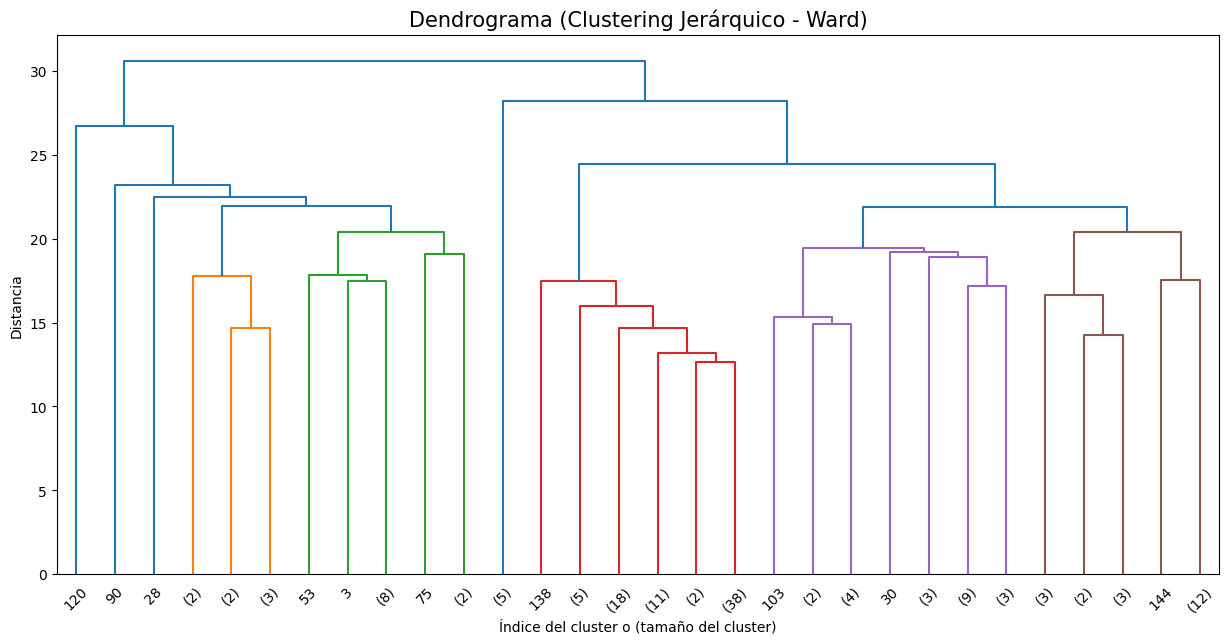

In [128]:
# Dendrograma usando una muestra si el dataset es muy grande
sample_size = min(500, len(X_scaled))
indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[indices]

plt.figure(figsize=(15, 7))
Z = linkage(X_sample, method='ward')
dendrogram(Z, truncate_mode='lastp', p=30)
plt.title('Dendrograma (Clustering Jerárquico - Ward)', fontsize=15)
plt.xlabel('Índice del cluster o (tamaño del cluster)')
plt.ylabel('Distancia')
plt.show()

## Aplicar K-Means con número óptimo de clusters

Puedes ajustar el valor de `n_clusters` basándote en los resultados anteriores

In [129]:
# Seleccionar número óptimo de clusters (ajusta según los gráficos anteriores)
optimal_k = 3  # Cambiar según tus resultados

# Aplicar K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Agregar clusters al dataframe original
df_cluster['cluster'] = clusters

# Métricas de calidad
silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
calinski = calinski_harabasz_score(X_scaled, clusters)

print(f"Clustering con k={optimal_k}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (menor es mejor)")
print(f"Calinski-Harabasz Score: {calinski:.2f} (mayor es mejor)")
print(f"\nDistribución de pacientes por cluster:")
print(df_cluster['cluster'].value_counts().sort_index())

Clustering con k=3
Silhouette Score: 0.2610
Davies-Bouldin Index: 2.7504 (menor es mejor)
Calinski-Harabasz Score: 10.73 (mayor es mejor)

Distribución de pacientes por cluster:
cluster
0     10
1     33
2    104
Name: count, dtype: int64


# Profiling de Clusters

Analizar qué variables discriminan mejor los clusters

In [130]:
## Análisis de Variables Numéricas
# Test ANOVA para variables numéricas

discriminant_power = {}

for var in vars_num:
    if var in df_cluster.columns:
        groups = [df_cluster[df_cluster['cluster'] == i][var].dropna() 
                  for i in range(optimal_k)]
        
        # Filtrar grupos vacíos
        groups = [g for g in groups if len(g) > 0]
        
        if len(groups) >= 2:
            f_stat, p_value = f_oneway(*groups)
            discriminant_power[var] = {'F-statistic': f_stat, 'p-value': p_value, 'type': 'numeric'}

# Ordenar por F-statistic
discriminant_df_num = pd.DataFrame(discriminant_power).T
discriminant_df_num = discriminant_df_num[discriminant_df_num['type'] == 'numeric'].sort_values('F-statistic', ascending=False)

print("Variables numéricas con mayor poder discriminante:")
print(discriminant_df_num[['F-statistic', 'p-value']])

Variables numéricas con mayor poder discriminante:
                  F-statistic   p-value
tamano_tumoral       8.445703   0.00034
imc                  4.493552  0.012792
valor_de_ca125       2.038183  0.134006
rece_de_Ppor         1.008388  0.367368
recep_est_porcent    0.710412  0.493156


In [131]:
## Análisis de Variables Categóricas
# Test Chi-cuadrado para variables categóricas

for var in vars_cat + vars_from_pre:
    if var in df_cluster.columns:
        # Crear tabla de contingencia
        contingency_table = pd.crosstab(df_cluster['cluster'], df_cluster[var])
        
        # Test chi-cuadrado
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        discriminant_power[var] = {'Chi2-statistic': chi2, 'p-value': p_value, 'type': 'categorical'}

# Ordenar por Chi2-statistic
discriminant_df_cat = pd.DataFrame(discriminant_power).T
discriminant_df_cat = discriminant_df_cat[discriminant_df_cat['type'] == 'categorical'].sort_values('Chi2-statistic', ascending=False)

print("\nVariables categóricas con mayor poder discriminante:")
print(discriminant_df_cat[['Chi2-statistic', 'p-value']])


Variables categóricas con mayor poder discriminante:
                          Chi2-statistic   p-value
afectacion_linf               171.014361       0.0
FIGO2023                      165.462518       0.0
histo_defin                   113.303644       0.0
FIGO2023__from_pre             86.945934       0.0
metasta_distan                 73.116522       0.0
AP_glanPaor                     56.97715       0.0
AP_ganPelv                     56.566988       0.0
grado_histologi                55.461832       0.0
AP_centinela_pelvico           54.735645       0.0
beta_cateninap                 46.057407       0.0
grado_histologi__from_pre      35.595172       0.0
asa                            21.958117  0.001232
histo_defin__from_pre           0.416293  0.812088


In [132]:
# Resumen de todas las variables más discriminantes
all_discriminant = pd.DataFrame(discriminant_power).T
all_discriminant['statistic'] = all_discriminant.apply(
    lambda row: row['F-statistic'] if row['type'] == 'numeric' else row['Chi2-statistic'], 
    axis=1
)
all_discriminant_sorted = all_discriminant.sort_values('statistic', ascending=False)

print("\n" + "="*70)
print("TOP 15 VARIABLES MÁS DISCRIMINANTES")
print("="*70)
print(all_discriminant_sorted[['type', 'statistic', 'p-value']].head(15))


TOP 15 VARIABLES MÁS DISCRIMINANTES
                                  type   statistic   p-value
afectacion_linf            categorical  171.014361       0.0
FIGO2023                   categorical  165.462518       0.0
histo_defin                categorical  113.303644       0.0
FIGO2023__from_pre         categorical   86.945934       0.0
metasta_distan             categorical   73.116522       0.0
AP_glanPaor                categorical   56.977150       0.0
AP_ganPelv                 categorical   56.566988       0.0
grado_histologi            categorical   55.461832       0.0
AP_centinela_pelvico       categorical   54.735645       0.0
beta_cateninap             categorical   46.057407       0.0
grado_histologi__from_pre  categorical   35.595172       0.0
asa                        categorical   21.958117  0.001232
tamano_tumoral                 numeric    8.445703   0.00034
imc                            numeric    4.493552  0.012792
valor_de_ca125                 numeric    2.0381

## Perfiles de los Clusters

Estadísticas descriptivas por cluster

In [133]:
# Perfiles de variables numéricas por cluster
print("\n" + "="*70)
print("PERFILES DE VARIABLES NUMÉRICAS POR CLUSTER")
print("="*70)

for var in vars_num:
    if var in df_cluster.columns:
        print(f"\n{var}:")
        profile = df_cluster.groupby('cluster')[var].agg(['mean', 'median', 'std', 'count'])
        print(profile.round(2))


PERFILES DE VARIABLES NUMÉRICAS POR CLUSTER

imc:
          mean  median   std  count
cluster                            
0        33.05   31.15  9.12     10
1        27.55   28.30  6.26     33
2        31.88   30.80  7.80    104

valor_de_ca125:
         mean  median   std  count
cluster                           
0        3.49    3.23  0.76     10
1        3.32    3.23  0.40     33
2        3.23    3.23  0.37    104

tamano_tumoral:
         mean  median   std  count
cluster                           
0        1.55    1.39  0.49     10
1        1.67    1.61  0.63     33
2        1.22    1.22  0.56    104

recep_est_porcent:
         mean  median   std  count
cluster                           
0        0.89     0.9  0.03     10
1        0.79     0.9  0.26     33
2        0.82     0.9  0.22    104

rece_de_Ppor:
         mean  median   std  count
cluster                           
0        0.65     0.8  0.32     10
1        0.77     0.8  0.15     33
2        0.73     0.8  0.26    104


In [134]:
# Perfiles de variables categóricas por cluster (% dentro de cada cluster)
print("\n" + "="*70)
print("PERFILES DE VARIABLES CATEGÓRICAS POR CLUSTER (%)")
print("="*70)

for var in vars_cat + vars_from_pre:
    if var in df_cluster.columns:
        print(f"\n{var}:")
        # Tabla de contingencia con porcentajes por cluster
        ct = pd.crosstab(df_cluster['cluster'], df_cluster[var], normalize='index') * 100
        print(ct.round(1))


PERFILES DE VARIABLES CATEGÓRICAS POR CLUSTER (%)

asa:
asa      0.0   1.0   2.0  Missing
cluster                          
0        0.0  50.0  30.0     20.0
1        3.0  45.5  33.3     18.2
2        7.7  71.2  20.2      1.0

histo_defin:
histo_defin   1.0   2.0   3.0  4.0  6.0  7.0   8.0   9.0
cluster                                                 
0            40.0  40.0   0.0  0.0  0.0  0.0   0.0  20.0
1             0.0  45.5  15.2  6.1  6.1  3.0  12.1  12.1
2             0.0  94.2   0.0  0.0  1.0  0.0   0.0   4.8

grado_histologi:
grado_histologi   1.0   2.0
cluster                    
0                70.0  30.0
1                36.4  63.6
2                95.2   4.8

FIGO2023:
FIGO2023   0.0   1.0  10.0  11.0  12.0  13.0  14.0   2.0   4.0  6.0  7.0  8.0  \
cluster                                                                         
0         60.0  20.0   0.0   0.0   0.0   0.0  10.0  10.0   0.0  0.0  0.0  0.0   
1          0.0   6.1   6.1  33.3   9.1   6.1   6.1   0.0  12.1

## Visualizaciones de Perfiles

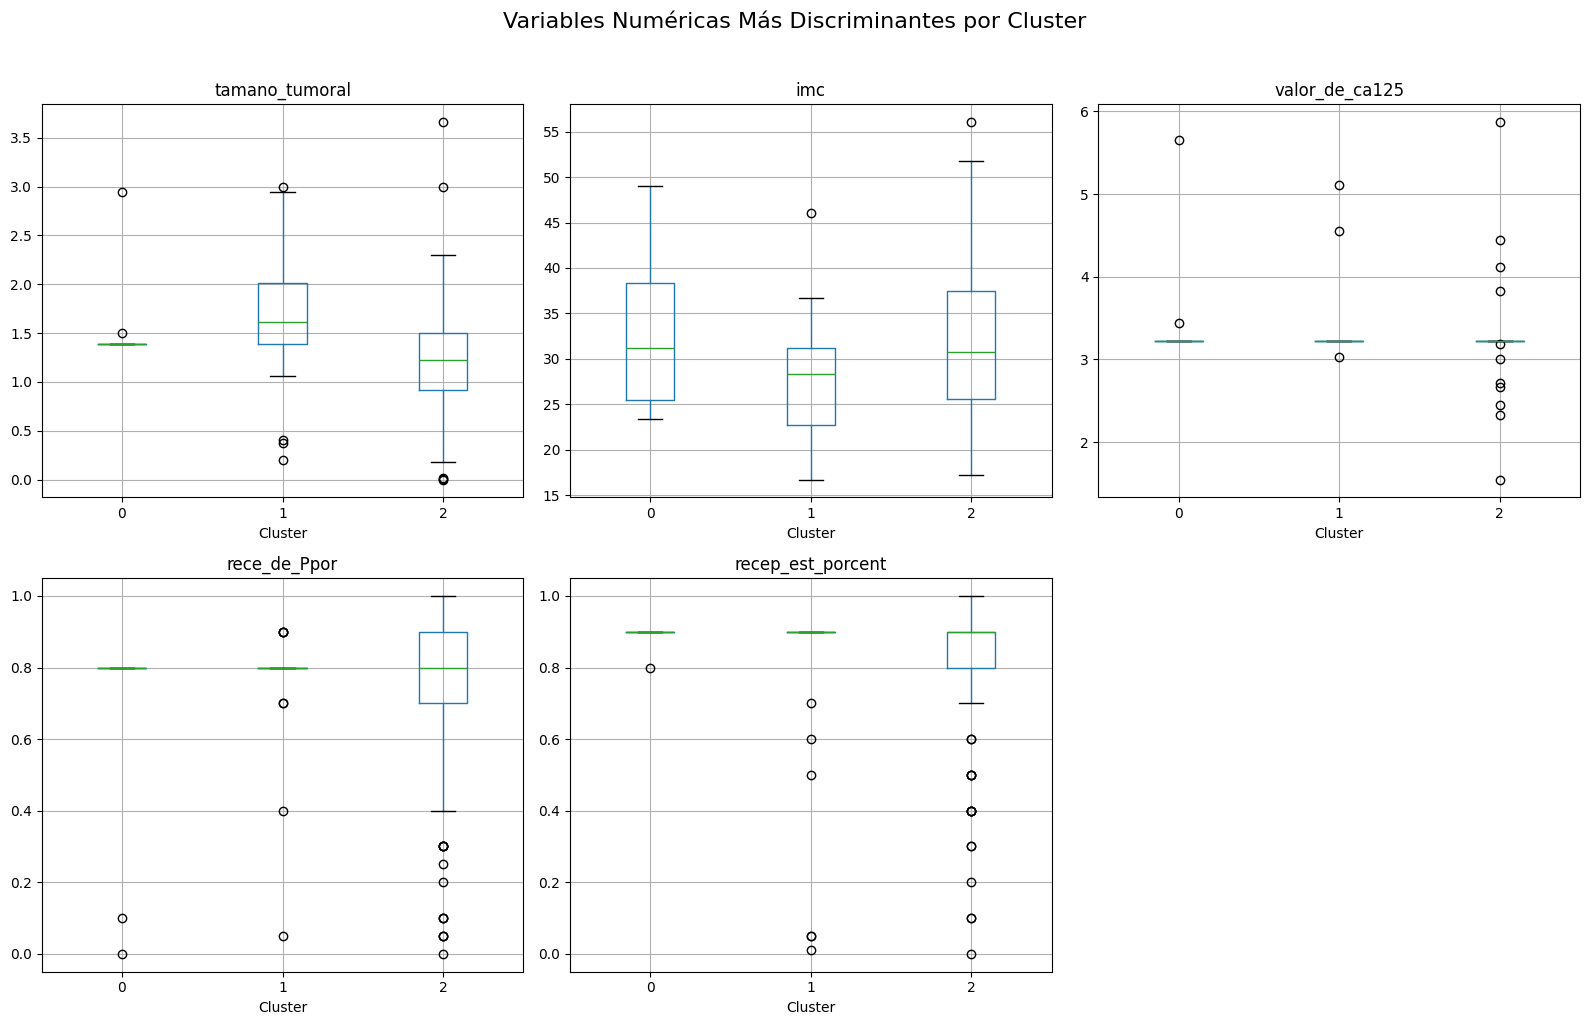

In [135]:
# Boxplots de las variables numéricas más discriminantes
top_vars_num = discriminant_df_num.head(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(top_vars_num):
    if i < len(axes):
        df_cluster.boxplot(column=var, by='cluster', ax=axes[i])
        axes[i].set_title(f'{var}')
        axes[i].set_xlabel('Cluster')
        
# Eliminar plots vacíos
for i in range(len(top_vars_num), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Variables Numéricas Más Discriminantes por Cluster', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

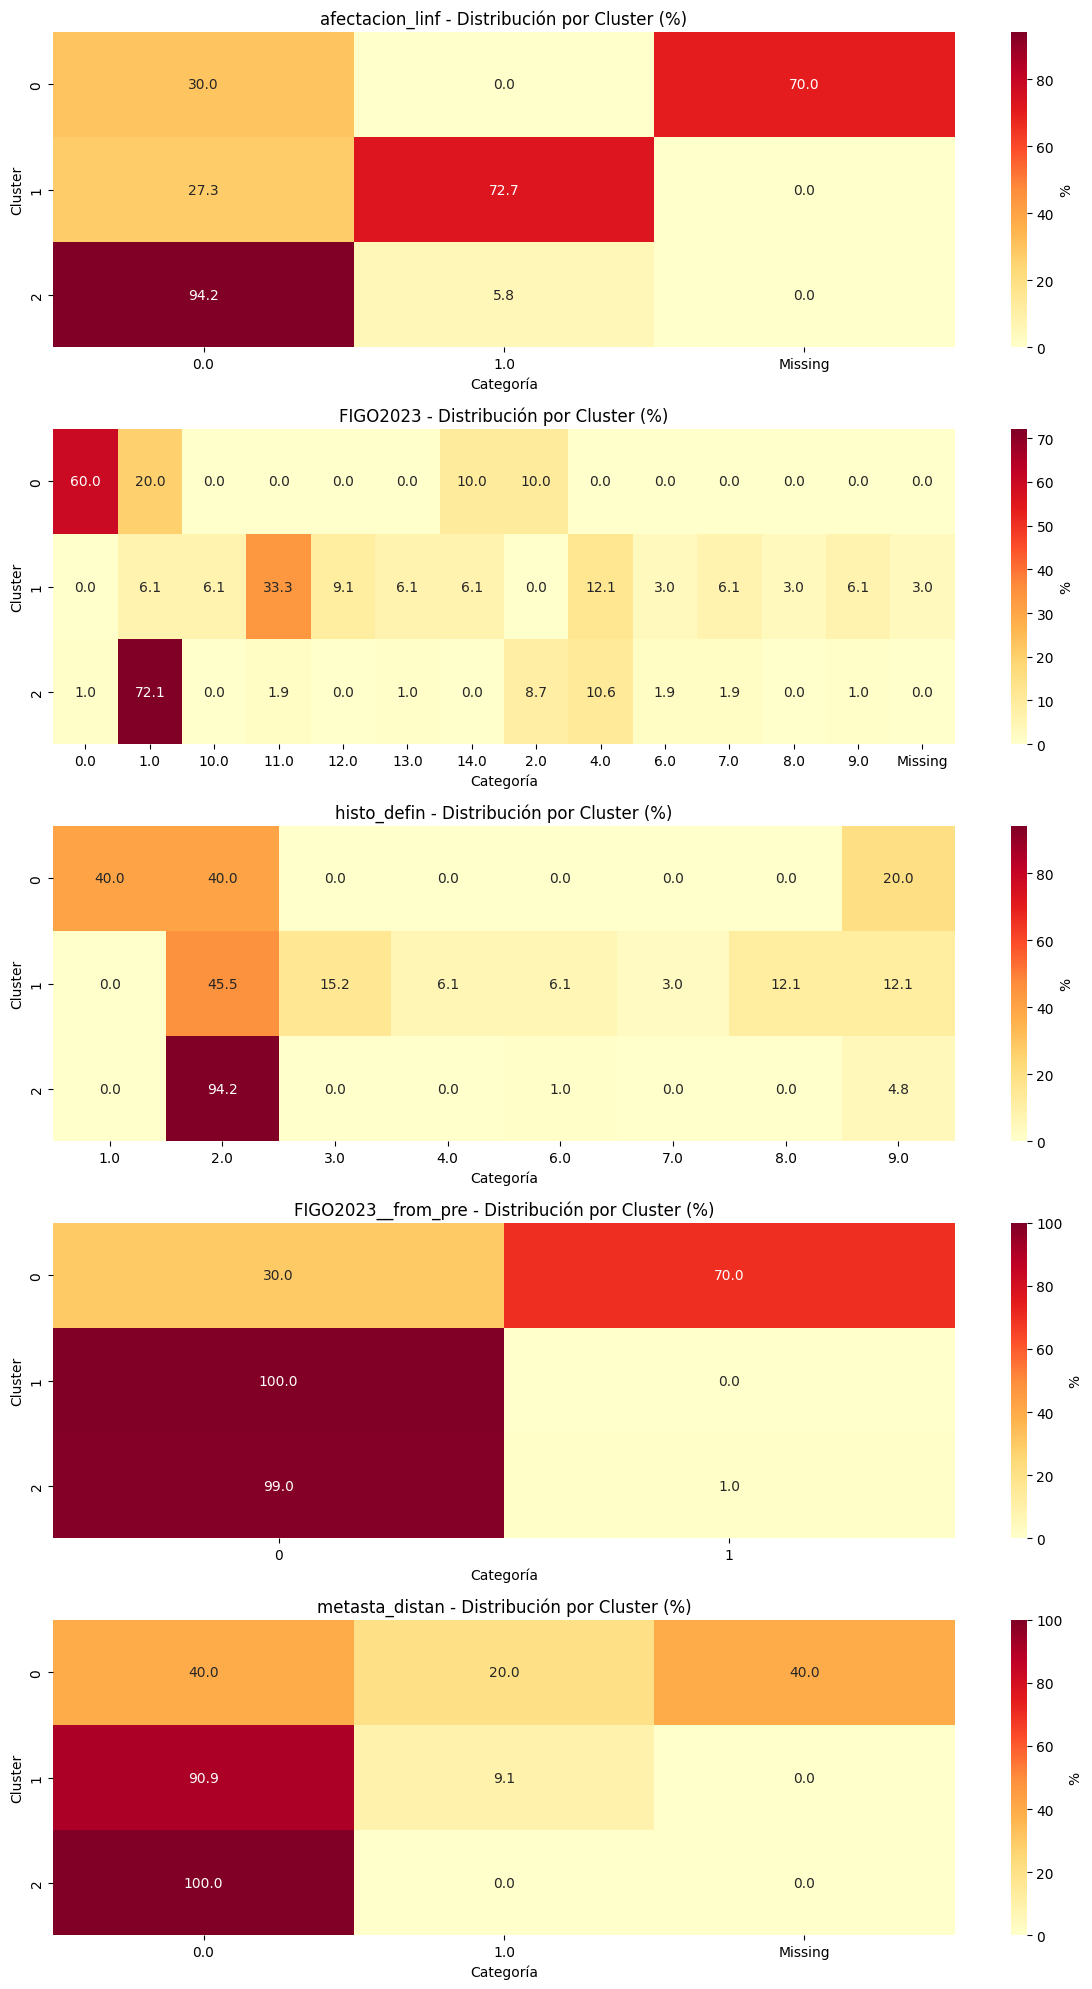

In [136]:
# Heatmap de las variables categóricas más discriminantes
top_vars_cat = discriminant_df_cat.head(5).index.tolist()

fig, axes = plt.subplots(len(top_vars_cat), 1, figsize=(12, 4*len(top_vars_cat)))

if len(top_vars_cat) == 1:
    axes = [axes]

for i, var in enumerate(top_vars_cat):
    ct = pd.crosstab(df_cluster['cluster'], df_cluster[var], normalize='index') * 100
    sns.heatmap(ct, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[i], cbar_kws={'label': '%'})
    axes[i].set_title(f'{var} - Distribución por Cluster (%)', fontsize=12)
    axes[i].set_xlabel('Categoría')
    axes[i].set_ylabel('Cluster')

plt.tight_layout()
plt.show()

## Análisis de Supervivencia por Cluster

Comparar los outcomes (event, time_days) entre clusters


ANÁLISIS DE SUPERVIVENCIA POR CLUSTER

Estadísticas por cluster:
        event             time_days                 edad_en_cirugia       
          sum  mean count      mean  median     std            mean    std
cluster                                                                   
0           3  0.30    10    427.00    31.5  676.70           59.10   5.51
1          23  0.70    33    867.97   715.0  629.89           67.49  13.16
2          11  0.11   104   1186.66  1159.0  621.97           62.06  11.58


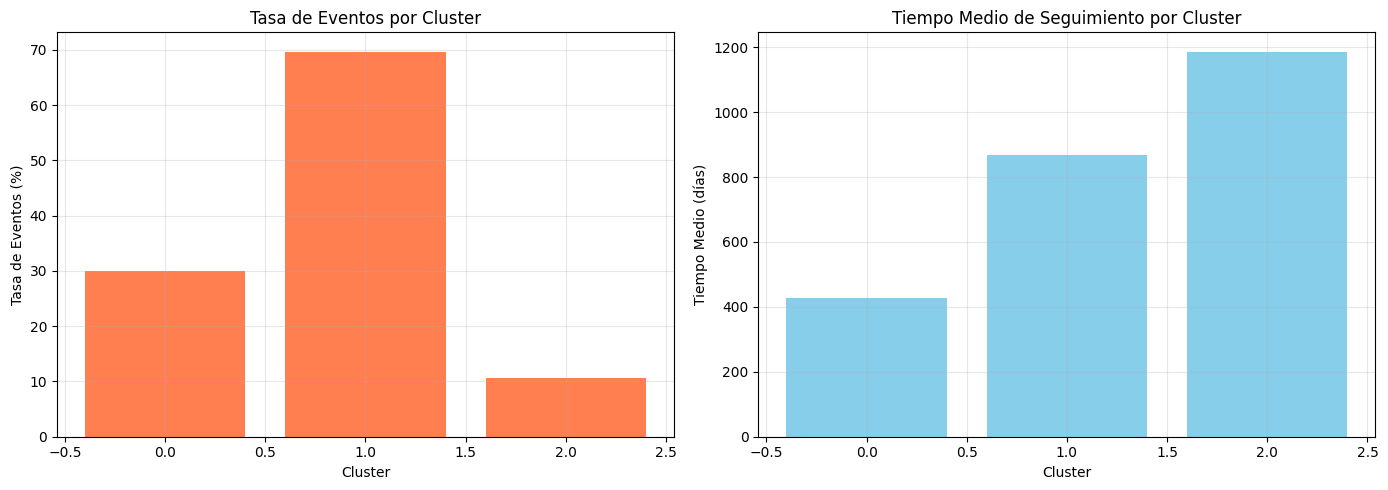

In [137]:
# Agregar cluster a df_reps para análisis de supervivencia
df_reps['cluster'] = clusters

# Estadísticas de supervivencia por cluster
print("\n" + "="*70)
print("ANÁLISIS DE SUPERVIVENCIA POR CLUSTER")
print("="*70)

survival_stats = df_reps.groupby('cluster').agg({
    'event': ['sum', 'mean', 'count'],
    'time_days': ['mean', 'median', 'std'],
    'edad_en_cirugia': ['mean', 'std']
})

print("\nEstadísticas por cluster:")
print(survival_stats.round(2))

# Gráfico de eventos por cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tasa de eventos por cluster
event_rate = df_reps.groupby('cluster')['event'].agg(['sum', 'count'])
event_rate['rate'] = (event_rate['sum'] / event_rate['count']) * 100

axes[0].bar(event_rate.index, event_rate['rate'], color='coral')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Tasa de Eventos (%)')
axes[0].set_title('Tasa de Eventos por Cluster')
axes[0].grid(True, alpha=0.3)

# Tiempo medio por cluster
time_by_cluster = df_reps.groupby('cluster')['time_days'].mean()
axes[1].bar(time_by_cluster.index, time_by_cluster.values, color='skyblue')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Tiempo Medio (días)')
axes[1].set_title('Tiempo Medio de Seguimiento por Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Guardar Resultados

In [138]:
# Preparar dataset para modelo Cox con clusters
df_cox = df_reps.copy()
df_cox['cluster'] = clusters

# También podemos agregar las variables más discriminantes
top_discriminant_vars = all_discriminant_sorted.head(10).index.tolist()
for var in top_discriminant_vars:
    if var in df_cluster.columns:
        df_cox[var] = df_cluster[var].values

# Guardar
df_cox.to_csv('Dades/datos_clustering_cox.csv', index=False)
print("Dataset para modelo Cox guardado en: Dades/datos_clustering_cox.csv")

# Guardar el dataset completo con clusters
df_cluster_full = df_cluster.copy()
df_cluster_full['edad_en_cirugia'] = df_reps['edad_en_cirugia'].values
df_cluster_full['event'] = df_reps['event'].values
df_cluster_full['time_days'] = df_reps['time_days'].values

df_cluster_full.to_csv('Dades/datos_con_clusters.csv', index=False)
print("Dataset completo con clusters guardado en: Dades/datos_con_clusters.csv")

# Guardar resumen de discriminación
all_discriminant_sorted.to_csv('Dades/variables_discriminantes.csv')
print("Variables discriminantes guardadas en: Dades/variables_discriminantes.csv")

Dataset para modelo Cox guardado en: Dades/datos_clustering_cox.csv
Dataset completo con clusters guardado en: Dades/datos_con_clusters.csv
Variables discriminantes guardadas en: Dades/variables_discriminantes.csv
